In [1]:
import numpy as np
import numba
from numba import jit, float64, farray, vectorize, cfunc, void, carray
from numpy import sin, cos, sqrt, pi, arctan2, exp, log
# from scipy.special import erf
from math import erf

import mfem.ser as mfem
from mfem.common.sparse_utils import sparsemat_to_scipycsr
from glvis import glvis

from scipy.sparse import lil_matrix, csr_matrix, coo_matrix

from bdr_utils import *

import matplotlib.pyplot as plt

In [2]:
quasi_dif = -2e-8

CoulLog = 15.
Zb = 1.
Za = 1.
nb = 1.0e20
vb = 8.8e6
va=vb*3.0
ma = 9.1093837015e-31
mb = 9.1093837015e-31
ee = 1.602176634e-19
em = 2.718281828459045
gamma = 4.0*pi*pow(Za,4.0)*pow(ee,4.0)/ma/ma

@jit(float64(float64, float64))
def pow(x, c):
    return x**c


@jit(void(float64, float64, float64[:]))
def v_theta(x, y, E):
    y = y if y > 0 else 0.0

    theta = arctan2(y, x)
    vel = sqrt(x**2 + y**2)
    vel = vel if vel != 0 else 1e-12
    E[0] = x*va
    E[1] = y*va
    E[2] = vel*va
    E[3] = theta

@jit(float64(float64))
def calc_A(vel):
    A = (((Zb/Za)**2)*CoulLog*ma/mb*nb*
         (-vel/vb*sqrt(2.0/pi)*exp(-pow(vel,2.0)/2.0/pow(vb,2.0))+erf(vel/sqrt(2.0)/vb)))
    return A

@jit(float64(float64))
def calc_dA(vel):
    dA = pow(Zb/Za,2.0)*CoulLog*ma/mb*nb*pow(vel,2.0)/pow(vb,3.0)*sqrt(2.0/pi)*exp(-pow(vel,2.0)/2.0/pow(vb,2.0))
    return dA

@mfem.jit.scalar()
def dA_func(p):
    E = np.empty(4, dtype = float64)
    v_theta(p[0], p[1], E)
    x = E[0]
    y = E[1]
    vel = E[2]
    theta = E[3]
    dA = calc_dA(vel)
    base = dA/vel*sin(theta)
    return gamma*base

# class dA_term(mfem.PyCoefficient):
#     def EvalValue(self, v):
#         return dA_func(v[0], v[1])

@mfem.jit.vector()
def A_func(p, out):
    out_array = carray(out, (2, ))
    E = np.empty(4, dtype = float64)
    v_theta(p[0], p[1], E)
    x = E[0]
    y = E[1]
    vel = E[2]
    theta = E[3]
    
    A = calc_A(vel)
    x = A*sin(theta)*cos(theta)/vel
    y = A*sin(theta)*sin(theta)/vel
    vec = np.array([x, y])
    out_array[0] = x/va*gamma
    out_array[1] = y/va*gamma

# class A_term(mfem.VectorPyCoefficient):
#     def EvalValue(self,v):
#         return A_func(v[0], v[1])

@mfem.jit.matrix(sdim = 2)
def BF_func(ptx, out):    
    E = np.empty(4, dtype = float64)
    v_theta(ptx[0], ptx[1], E)
    x = E[0]
    y = E[1]
    vel = E[2]
    theta = E[3]
    
    mat = carray(out, (2,2))
    
    A = calc_A(vel)

    B = (vb**2)*mb/vel/ma*A
    FWoSin = (pow(Zb/Za,2.0)*CoulLog*nb/2.0/vel*(vb/vel*sqrt(2.0/pi)*exp(-pow(vel,2.0)/2.0/pow(vb,2.0))
              +(1.0-pow(vb,2.0)/pow(vel,2.0))*erf(vel/sqrt(2.0)/vb)))
    F = FWoSin*sin(theta);

    #double check matrix indices
    mat[0,0] = B*sin(theta)*cos(theta)*cos(theta)/vel+vel*F*sin(theta)*sin(theta)
    mat[1,0] = B*sin(theta)*sin(theta)*cos(theta)/vel-vel*F*cos(theta)*sin(theta)
    mat[0,1] = B*sin(theta)*sin(theta)*cos(theta)/vel-vel*F*cos(theta)*sin(theta)
    mat[1,1] = B*sin(theta)*sin(theta)*sin(theta)/vel+vel*F*cos(theta)*cos(theta)
    
    mat*=-1.0/va/va*gamma

@mfem.jit.matrix(sdim = 2)
def quasi_func(ptx, out):    
    mat = carray(out, (2,2))
    x = ptx[0]

    w1 = 0.2
    w2 = 0.6
    mat[0,1] = 0.0
    mat[1,0] = 0.0
    mat[1,1] = 0.0
    mat[0,0] = 0.0

    if ((x < w2) and (x > w1)):
        mat[0,0] = quasi_dif


In [3]:
order = 3
dim = 2

mesh = mfem.Mesh("data/semi_circle3.msh")
fec = mfem.H1_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)

zero = mfem.ConstantCoefficient(0.0)

In [4]:
ess_tdof = mfem.intArray()
ess_bdr = mfem.intArray(mesh.bdr_attributes.Size())
ess_bdr.Assign(0)
ess_bdr[2] = 1
ess_bdr[4] = 1
fes.GetEssentialTrueDofs(ess_bdr, ess_tdof)

bilin = mfem.BilinearForm(fes)
bilin.AddDomainIntegrator(mfem.DiffusionIntegrator(BF_func))
bilin.AddDomainIntegrator(mfem.DiffusionIntegrator(quasi_func))
bilin.AddDomainIntegrator(mfem.ConvectionIntegrator(A_func))
bilin.AddDomainIntegrator(mfem.MassIntegrator(dA_func))
bilin.Assemble()

lin = mfem.LinearForm(fes)
lin.AddDomainIntegrator(mfem.DomainLFIntegrator(zero))
lin.Assemble()

x = mfem.GridFunction(fes)
x.Assign(1.0)

A = mfem.OperatorPtr()
B = mfem.Vector()
X = mfem.Vector()
bilin.FormLinearSystem(ess_tdof, x, lin, A, X, B)

In [5]:
atol=1e-15
rtol=1e-10
maxIter=500

psolver=mfem.GMRESSolver()
psolver.SetAbsTol(atol)
psolver.SetRelTol(rtol)
psolver.SetMaxIter(maxIter)
psolver.SetOperator(A.Ptr())
psolver.SetPrintLevel(-1)

atol=1e-15
rtol=1e-10
maxIter=1000

solver=mfem.FGMRESSolver()
solver.SetAbsTol(atol)
solver.SetRelTol(rtol)
solver.SetMaxIter(maxIter)
solver.SetOperator(A.Ptr())
solver.SetPrintLevel(1)
solver.SetPreconditioner(psolver)

sol = mfem.GridFunction(fes)

solver.Mult(B, sol)
print(sol.GetDataArray())

[ 1.         39.66907969  1.         ... 10.64105242  1.12087626
  1.05601319]


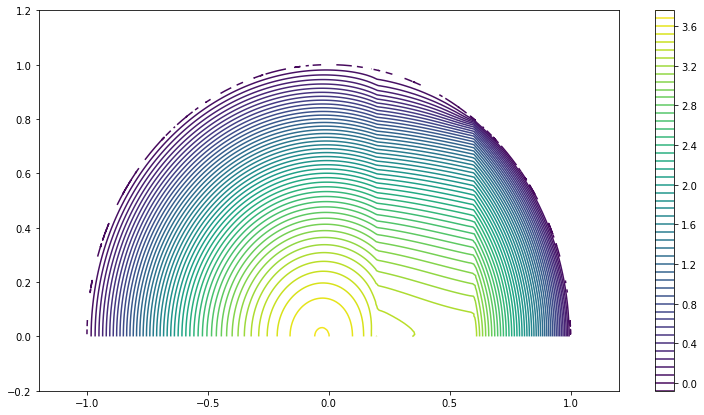

In [6]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

%matplotlib inline
# %matplotlib qt

@mfem.jit.scalar()
def x(p):
    return p[0]
@mfem.jit.scalar()
def y(p):
    return p[1]

def dom_plot(sol_gf, fes, axes, flip = False, return_tpc = False):
    x_gf = mfem.GridFunction(fes)
    y_gf = mfem.GridFunction(fes)
    
    x_gf.ProjectCoefficient(x)
    y_gf.ProjectCoefficient(y)
    
    if (flip):
        triang = tri.Triangulation(x_gf.GetDataArray()*-1, y_gf.GetDataArray())
    else:
        triang = tri.Triangulation(x_gf.GetDataArray(), y_gf.GetDataArray())
#     tpc = axes.tripcolor(triang, log(sol_gf.GetDataArray()))#, shading='gouraud')
    tpc = axes.tricontour(triang, log(sol_gf.GetDataArray()), levels = 50) #, shading='gouraud')
    
    if (return_tpc):
        return tpc
        

fig, ax = plt.subplots(figsize = (13,7))

tpc = dom_plot(sol, fes, ax, False, True)
fig.colorbar(tpc)

plt.xlim(-1.2,1.2)
plt.ylim(-0.2,1.2)
plt.show()